In [5]:
import sys
import time
import datetime
from qudi.util.network import netobtain
import matplotlib.pyplot as plt
import importlib
sys.path.append('../xq1i')
import libxq1i
importlib.reload(libxq1i)

confocal2 = libxq1i.xq1i(pulsed_master_logic, pulsed_measurement_logic, sequence_generator_logic)

go to POI POI_01 ...
... position and counts at peak after refocus: (72.930, 84.898, -3.807) µm,  σ= (0.252, 0.412, 0.813) µm, peak cnts: 5.99E+06
start measurements for orientation 1 ...


 ... rabi:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

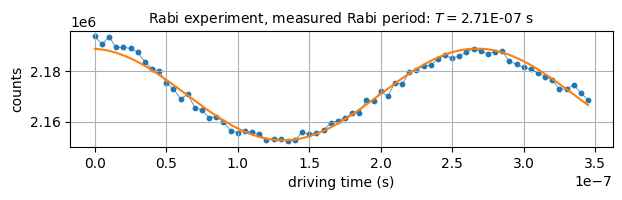

 ... pulsedODMR:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

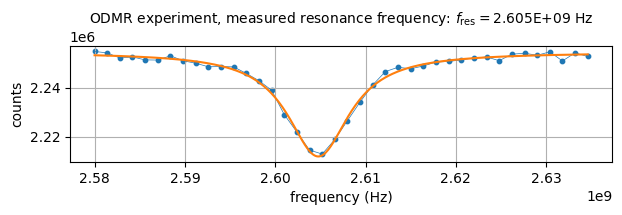

 ... hahn_echo:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

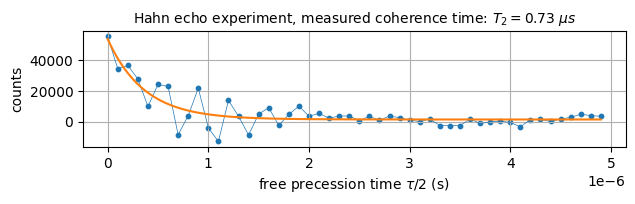

 ... xy8_order:   0%|          | 0/2000000.0 [00:00<?, ?sweeps/s]

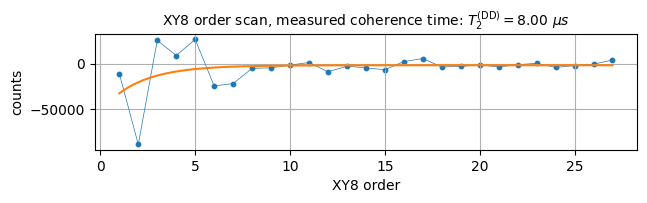

 ... ramsey:   0%|          | 0/2000000.0 [00:00<?, ?sweeps/s]

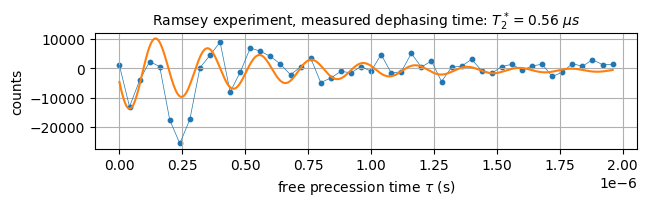

start measurements for orientation 2 ...


 ... rabi:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

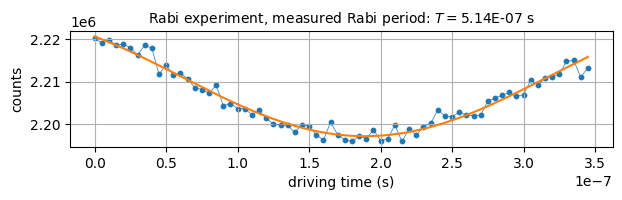

 ... pulsedODMR:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

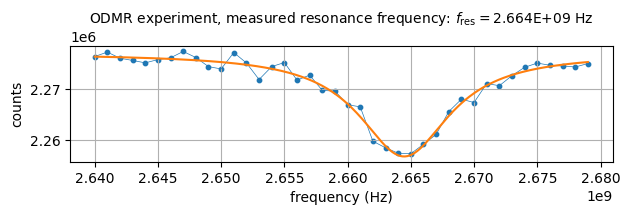

 ... hahn_echo:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

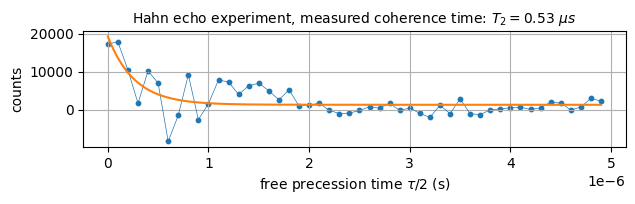

 ... xy8_order:   0%|          | 0/2000000.0 [00:00<?, ?sweeps/s]

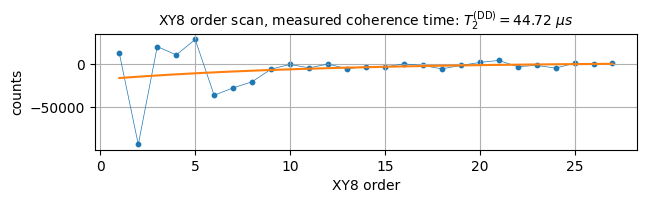

 ... ramsey:   0%|          | 0/2000000.0 [00:00<?, ?sweeps/s]

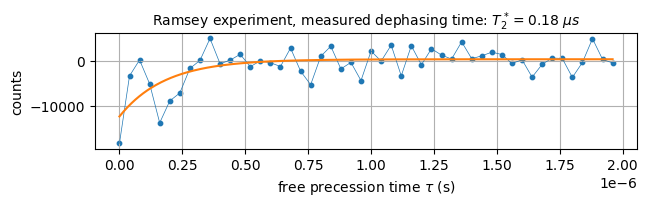

start measurements for orientation 3 ...


 ... rabi:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

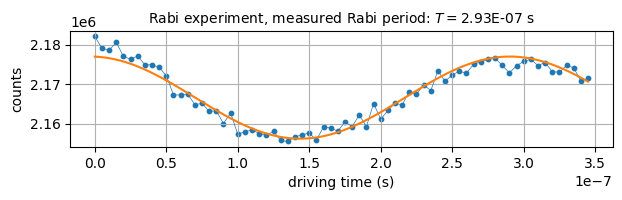

 ... pulsedODMR:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

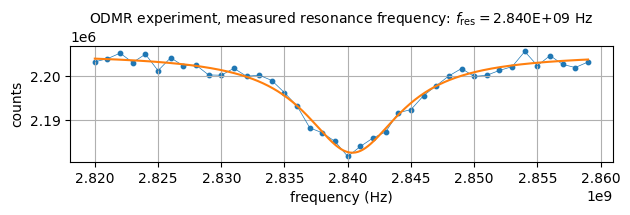

 ... hahn_echo:   0%|          | 0/1000000.0 [00:00<?, ?sweeps/s]

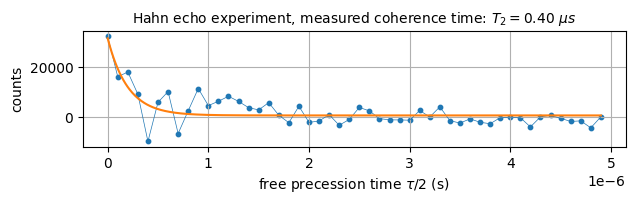

 ... xy8_order:   0%|          | 0/2000000.0 [00:00<?, ?sweeps/s]

KeyboardInterrupt: 

In [6]:
outputFilename = f"characterization_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.txt"
outputFile = open(outputFilename, 'w')

orientation_properties = {
    1: {'res_freq': 2.605e9, 'freq_range': [2580.0e6, 1.4e6, 40],  'rabi_period': 2.73e-7},
    2: {'res_freq': 2.665e9, 'freq_range': [2640.0e6, 1.0e6, 40],  'rabi_period': 4.83e-7},
    3: {'res_freq': 2.840e9, 'freq_range': [2820.0e6, 1.0e6, 40], 'rabi_period': 2.93e-7},
    4: {'res_freq': 2.887e9, 'freq_range': [2870.0e6, 1.0e6, 40], 'rabi_period': 1/9.9e6},
}

poi_list = [
    #{'poi': 'POI_40', 'orientations': [2,4]},
    #{'poi': 'POI_54', 'orientations': [3,4]},
    #{'poi': 'POI_61', 'orientations': [1,2,3,4]},
    {'poi': 'POI_01', 'orientations': [1,2,3,4]},
]


pulsed_master_logic.clear_pulse_generator()
time.sleep(1)

for entry in poi_list:
    currPoi = entry['poi']
    print(f'go to POI {currPoi} ...')
    # disable tracking before moving to the next POI
    poi_manager_logic.toggle_periodic_refocus(False)
    # wait until an ongoing optimization is terminated
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    # move to next POI
    poi_manager_logic.go_to_poi(currPoi)
    poi_manager_logic.set_active_poi(currPoi)
    # enable tracking of POI
    poi_manager_logic.toggle_periodic_refocus(True)
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    print( '... position and counts at peak after refocus: ' + scanner_gui.optimizer_dockwidget.result_label.text() )

    for orientation in entry['orientations']:
        print(f'start measurements for orientation {orientation} ...')
        countsStart = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        # Rabi
        confocal2.generate_params['microwave_frequency'] = orientation_properties[orientation]['res_freq']
        if currPoi == 'POI_58' and orientation == 1:
            # POI_58_ornt_1 has a shifted resonance, account for it
            confocal2.generate_params['microwave_frequency'] += 14e6
        confocal2.generate_params['microwave_frequency']
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        confocal2.rabi_sweeps = 1e6
        #confocal2.rabi_sweeps = 2e6
        confocal2.do_rabi( f'{currPoi}_ornt_{orientation}', isSlow=True )
        result_dict = netobtain( pulsed_measurement_logic.do_fit('Sine') )
        rabi_period = 1 / result_dict.params['frequency'].value
        tData = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData = netobtain(pulsed_measurement_logic.signal_data[1])
        plt.figure(figsize=(7, 1.5))
        plt.plot(tData, sigData, linewidth=0.5)
        plt.scatter(tData, sigData, s=10)
        plt.plot(result_dict.high_res_best_fit[0], result_dict.high_res_best_fit[1])
        plt.grid()
        plt.title(rf'Rabi experiment, measured Rabi period: $T =${rabi_period:.2E} s', fontsize=10)
        plt.ylabel('counts')
        plt.xlabel(r'driving time (s)')
        plt.show()
        
        # pulsed ODMR
        confocal2.pulsedODMR_params['freq_start'] = orientation_properties[orientation]['freq_range'][0]
        confocal2.pulsedODMR_params['freq_step'] = orientation_properties[orientation]['freq_range'][1]
        confocal2.pulsedODMR_params['num_of_points'] = orientation_properties[orientation]['freq_range'][2]
        confocal2.generate_params['rabi_period'] = rabi_period
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        confocal2.pulsedODMR_sweeps = 1e6
        #confocal2.pulsedODMR_sweeps = 2e6
        confocal2.do_pulsedODMR( f'{currPoi}_ornt_{orientation}')
        result_dict = netobtain( pulsed_measurement_logic.do_fit('Lorentzian Dip') )
        res_freq = result_dict.params['center'].value
        confocal2.generate_params['microwave_frequency'] = res_freq
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        fData = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData = netobtain(pulsed_measurement_logic.signal_data[1])
        plt.figure(figsize=(7, 1.5))
        plt.plot(fData, sigData, linewidth=0.5)
        plt.scatter(fData, sigData, s=10)
        plt.plot(result_dict.high_res_best_fit[0], result_dict.high_res_best_fit[1])
        plt.grid()
        plt.title(rf'ODMR experiment, measured resonance frequency: $f_\mathrm{{res}} =${res_freq:.3E} Hz', fontsize=10)
        plt.ylabel('counts')
        plt.xlabel(r'frequency (Hz)')
        plt.show()

        if ( (rabi_period < orientation_properties[orientation]['rabi_period']/2 or  rabi_period > orientation_properties[orientation]['rabi_period']*2) 
             and (abs(res_freq - orientation_properties[orientation]['res_freq']) > 5e6) ):
            print(f'{currPoi}, orientation {orientation} not visible according to measured Rabi and ODMR signals. Proceeding with next orientation.')
            rabi_period = 0
            res_freq = 0
            t2 = 0
            t2star = 0
        else:
            # second Rabi in case the measured ODMR resonance is off by more than 1 MHz
            if abs(res_freq - orientation_properties[orientation]['res_freq']) > 1e6:
                confocal2.rabi_sweeps = 1e6
                #confocal2.rabi_sweeps = 2e6
                confocal2.do_rabi( f'{currPoi}_ornt_{orientation}', isSlow=True )
                result_dict = netobtain( pulsed_measurement_logic.do_fit('Sine') )
                rabi_period = 1 / result_dict.params['frequency'].value
                confocal2.generate_params['rabi_period'] = rabi_period
                pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
                tData = netobtain(pulsed_measurement_logic.signal_data[0])
                sigData = netobtain(pulsed_measurement_logic.signal_data[1])
                plt.figure(figsize=(7, 1.5))
                plt.plot(tData, sigData, linewidth=0.5)
                plt.scatter(tData, sigData, s=10)
                plt.plot(result_dict.high_res_best_fit[0], result_dict.high_res_best_fit[1])
                plt.grid()
                plt.title(rf'Rabi experiment, measured Rabi period: $T =${rabi_period:.2E} s', fontsize=10)
                plt.ylabel('counts')
                plt.xlabel(r'driving time (s)')
                plt.show()
            
            # Hahn echo (T_2)
            confocal2.hahn_sweeps = 1e6
            confocal2.do_echo( f'{currPoi}_ornt_{orientation}' )
            result_dict = netobtain(pulsed_measurement_logic.do_fit('Exp Decay', use_alternative_data=True))
            t2 = 2*result_dict.params['decay'].value
            tData = netobtain(pulsed_measurement_logic.signal_data[0])
            sigData = netobtain(pulsed_measurement_logic.signal_data[1]) - netobtain(pulsed_measurement_logic.signal_data[2])
            plt.figure(figsize=(7, 1.5))
            plt.plot(tData, sigData, linewidth=0.5)
            plt.scatter(tData, sigData, s=10)
            plt.plot(result_dict.high_res_best_fit[0], result_dict.high_res_best_fit[1])
            plt.grid()
            plt.title(rf'Hahn echo experiment, measured coherence time: $T_2 =${t2 * 1e6:.2f} $\mu s$', fontsize=10)
            plt.ylabel('counts')
            plt.xlabel(r'free precession time $\tau/2$ (s)')
            plt.show()

            # XY8 order scan (T_2 with DD)
            confocal2.xy8_order_sweeps = 2e6
            #clear pulser before uploading a long sequence, otherwise the AWG hangs
            pulsed_master_logic.clear_pulse_generator()
            time.sleep(1)
            confocal2.do_XY8_Orderscan( f'{currPoi}_ornt_{orientation}' )
            result_dict = netobtain(pulsed_measurement_logic.do_fit('Exp Decay', use_alternative_data=True))
            t2_dd = 2*confocal2.xy8_order_params['half_tau']*8 * result_dict.params['decay'].value
            tData = netobtain(pulsed_measurement_logic.signal_data[0])
            sigData = netobtain(pulsed_measurement_logic.signal_data[1]) - netobtain(pulsed_measurement_logic.signal_data[2])
            plt.figure(figsize=(7, 1.5))
            plt.plot(tData, sigData, linewidth=0.5)
            plt.scatter(tData, sigData, s=10)
            plt.plot(result_dict.high_res_best_fit[0], result_dict.high_res_best_fit[1])
            plt.grid()
            plt.title(rf'XY8 order scan, measured coherence time: $T^\mathrm{{(DD)}}_2 =${t2_dd * 1e6:.2f} $\mu s$', fontsize=10)
            plt.ylabel('counts')
            plt.xlabel(r'XY8 order')
            plt.show()
            #clear pulser before uploading the next sequence, otherwise the AWG hangs
            pulsed_master_logic.clear_pulse_generator()
            time.sleep(1)
    
            # Ramsey (T*_2)
            confocal2.generate_params['microwave_frequency'] = res_freq - 3e6
            pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
            confocal2.ramsey_sweeps = 2e6
            confocal2.ramsey_params['tau_step'] = 40.0e-9
            confocal2.do_ramsey( f'{currPoi}_ornt_{orientation}' )
            result_dict = netobtain(pulsed_measurement_logic.do_fit('Exp. Decay Sine', use_alternative_data=True))
            t2star = result_dict.params['decay'].value
            tData = netobtain(pulsed_measurement_logic.signal_data[0])
            sigData = netobtain(pulsed_measurement_logic.signal_data[2]) - netobtain(pulsed_measurement_logic.signal_data[1])
            plt.figure(figsize=(7, 1.5))
            plt.plot(tData, sigData, linewidth=0.5)
            plt.scatter(tData, sigData, s=10)
            plt.plot( result_dict.high_res_best_fit[0], -result_dict.high_res_best_fit[1])
            plt.grid()
            plt.title(rf'Ramsey experiment, measured dephasing time: $T_2^* =${t2star * 1e6:.2f} $\mu s$', fontsize=10)
            plt.ylabel('counts')
            plt.xlabel(r'free precession time $\tau$ (s)')
            plt.show()

        while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
            time.sleep(0.1)
        countsEnd = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        #outputFile.write( f"{currPoi}\t{orientation}\t{countsStart}\t{countsEnd}\t{res_freq:.4E}\t{rabi_period:.2E}\t{t2:.2E}\t{t2star:.2E}\n" )
        outputFile.write( f"{currPoi}\t{orientation}\t{countsStart}\t{countsEnd}\t{res_freq:.4E}\t{rabi_period:.2E}\t{t2:.2E}\t{t2_dd:.2E}\t{t2star:.2E}\n" )
        outputFile.flush()

print('... all POIs in the list measured')
outputFile.close()

In [3]:
import os
os.getcwd()

'C:\\Users\\XQ1\\.conda\\envs\\qudi2024\\qudi-iqo-modules\\src\\qudi\\xeedq_scripts'